# 07. AI 코드 생성 및 실행 시스템

## AutoGen Core 기반 AI 에이전트 시스템
### 워크플로우
1. 사용자 요청 → Assistant 에이전트 (코드 생성)
2. Executor 에이전트 (코드 실행) → 결과 시각화

AutoGen Core를 사용하여 맞춤형 AI 에이전트 시스템을 구현합니다.
- Assistant: 코드 생성
- Executor: 코드 실행

## 1. 라이브러리 및 에이전트 정의
AutoGen Core 기반 에이전트 시스템 구현

### 🤖 **에이전트 구조**:
- **Message 클래스**: 에이전트 간 통신용 데이터 구조
- **Assistant 에이전트**: AI 모델을 사용한 코드 생성 에이전트
- **Executor 에이전트**: Python 코드 실행 전담 에이전트
- **extract_markdown_code_blocks()**: 마크다운에서 코드 블록 추출 함수

**실행 결과**: 두 개의 전문화된 에이전트 클래스가 정의됩니다.

In [10]:
import re
from dataclasses import dataclass
from typing import List

from autogen_core import DefaultTopicId, MessageContext, RoutedAgent, default_subscription, message_handler
from autogen_core.code_executor import CodeBlock, CodeExecutor
from autogen_core.models import (
    AssistantMessage,
    ChatCompletionClient,
    LLMMessage,
    SystemMessage,
    UserMessage,
)


@dataclass
class Message:
    content: str


@default_subscription
class Assistant(RoutedAgent):
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("어시스턴트 에이전트입니다.")
        self._model_client = model_client
        self._chat_history: List[LLMMessage] = [
            SystemMessage(
                content="""                
                    마크다운 블록에 Python 스크립트를 작성하면 실행됩니다.
                    항상 그림을 현재 디렉토리의 파일로 저장하세요. plt.show()는 사용하지 마세요. plt.savefig()를 사용할 때는 파일명을 'result.png'로 해야 합니다.
                    이 작업을 완료하는 데 필요한 모든 코드는 하나의 응답에 포함되어야 합니다.
                """,
            )
        ]

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        self._chat_history.append(UserMessage(content=message.content, source="user"))
        result = await self._model_client.create(self._chat_history)
        print(f"\n{'-'*80}\nAssistant:\n{result.content}")
        self._chat_history.append(AssistantMessage(content=result.content, source="assistant"))  # type: ignore
        await self.publish_message(Message(content=result.content), DefaultTopicId())  # type: ignore


def extract_markdown_code_blocks(markdown_text: str) -> List[CodeBlock]:
    pattern = re.compile(r"```(?:\s*([\w\+\-]+))?\n([\s\S]*?)```")
    matches = pattern.findall(markdown_text)
    code_blocks: List[CodeBlock] = []
    for match in matches:
        language = match[0].strip() if match[0] else ""
        code_content = match[1]
        code_blocks.append(CodeBlock(code=code_content, language=language))
    return code_blocks


@default_subscription
class Executor(RoutedAgent):
    def __init__(self, code_executor: CodeExecutor) -> None:
        super().__init__("코드 실행 에이전트입니다.")
        self._code_executor = code_executor

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        code_blocks = extract_markdown_code_blocks(message.content)
        if code_blocks:
            result = await self._code_executor.execute_code_blocks(
                code_blocks, cancellation_token=ctx.cancellation_token
            )
            print(f"\n{'-'*80}\nExecutor:\n{result.output}")
            await self.publish_message(Message(content=result.output), DefaultTopicId())


이미 눈치채셨을 수도 있지만, 에이전트의 로직(모델이나 코드 실행기 사용 여부와 관계없이)은 메시지가 전달되는 방식과 완전히 분리되어 있습니다. 이것이 핵심 아이디어입니다: 프레임워크는 통신 인프라를 제공하고, 에이전트는 자체 로직에 대한 책임을 집니다. 우리는 이 통신 인프라를 **에이전트 런타임**이라고 부릅니다.

에이전트 런타임은 이 프레임워크의 핵심 개념입니다. 메시지 전달 외에도 에이전트의 생명주기를 관리합니다. 따라서 에이전트의 생성은 런타임에서 처리됩니다.

다음 코드는 로컬 임베디드 에이전트 런타임 구현인 {py:class}`~autogen_core.SingleThreadedAgentRuntime`을 사용하여 에이전트를 등록하고 실행하는 방법을 보여줍니다.


## ⚙️ 2. 환경 설정 및 코드 실행기 구현

**목적**: Azure OpenAI 연동 및 로컬 Python 코드 실행 시스템 구축

### 🔑 **Azure OpenAI 설정**:
- 환경 변수에서 API 키와 엔드포인트 로드
- GPT 모델 클라이언트 생성 및 초기화
- 연결 상태 확인 및 설정 정보 출력

### 🐍 **SimpleCodeExecutor 클래스**:
- **기능**: Docker 없이 로컬에서 Python 코드 직접 실행
- **안전장치**: 30초 타임아웃, 예외 처리, 출력 캡처
- **작업 방식**: 임시 파일 생성 → subprocess 실행 → 결과 반환

### 🚀 **에이전트 런타임 시스템**:
- SingleThreadedAgentRuntime으로 에이전트 등록
- Assistant와 Executor 에이전트 상호 통신 설정
- "마이크로소프트와 애플 주가 차트" 작업 실행

**실행 결과**: 완전한 AI 코드 생성 및 실행 시스템이 동작합니다.

## 🖼️ 3. 생성된 차트 확인 및 표시

**목적**: AI가 생성하고 실행한 코드의 결과물(차트) 확인

### 📁 **파일 시스템 작업**:
- 작업 디렉토리에서 `result.png` 파일 검색
- 파일 존재 여부 확인 및 경로 출력
- 오류 발생 시 디렉토리 내용 상세 분석

### 🖥️ **시각화 기능**:
- Jupyter 노트북에서 이미지 직접 표시
- PNG 파일을 인라인으로 렌더링
- 파일 크기 및 메타데이터 정보 제공

### 🔍 **디버깅 지원**:
- 작업 디렉토리 전체 파일 목록 출력
- 각 파일의 크기 정보 표시
- 오류 상황에 대한 상세한 진단 정보

**실행 결과**: Microsoft와 Apple 주가 시뮬레이션 차트가 노트북에 표시됩니다.

📈 Collecting Microsoft and Apple stock data from 2024...
✅ Microsoft (MSFT) data collected: 461 trading days
✅ Apple (AAPL) data collected: 461 trading days


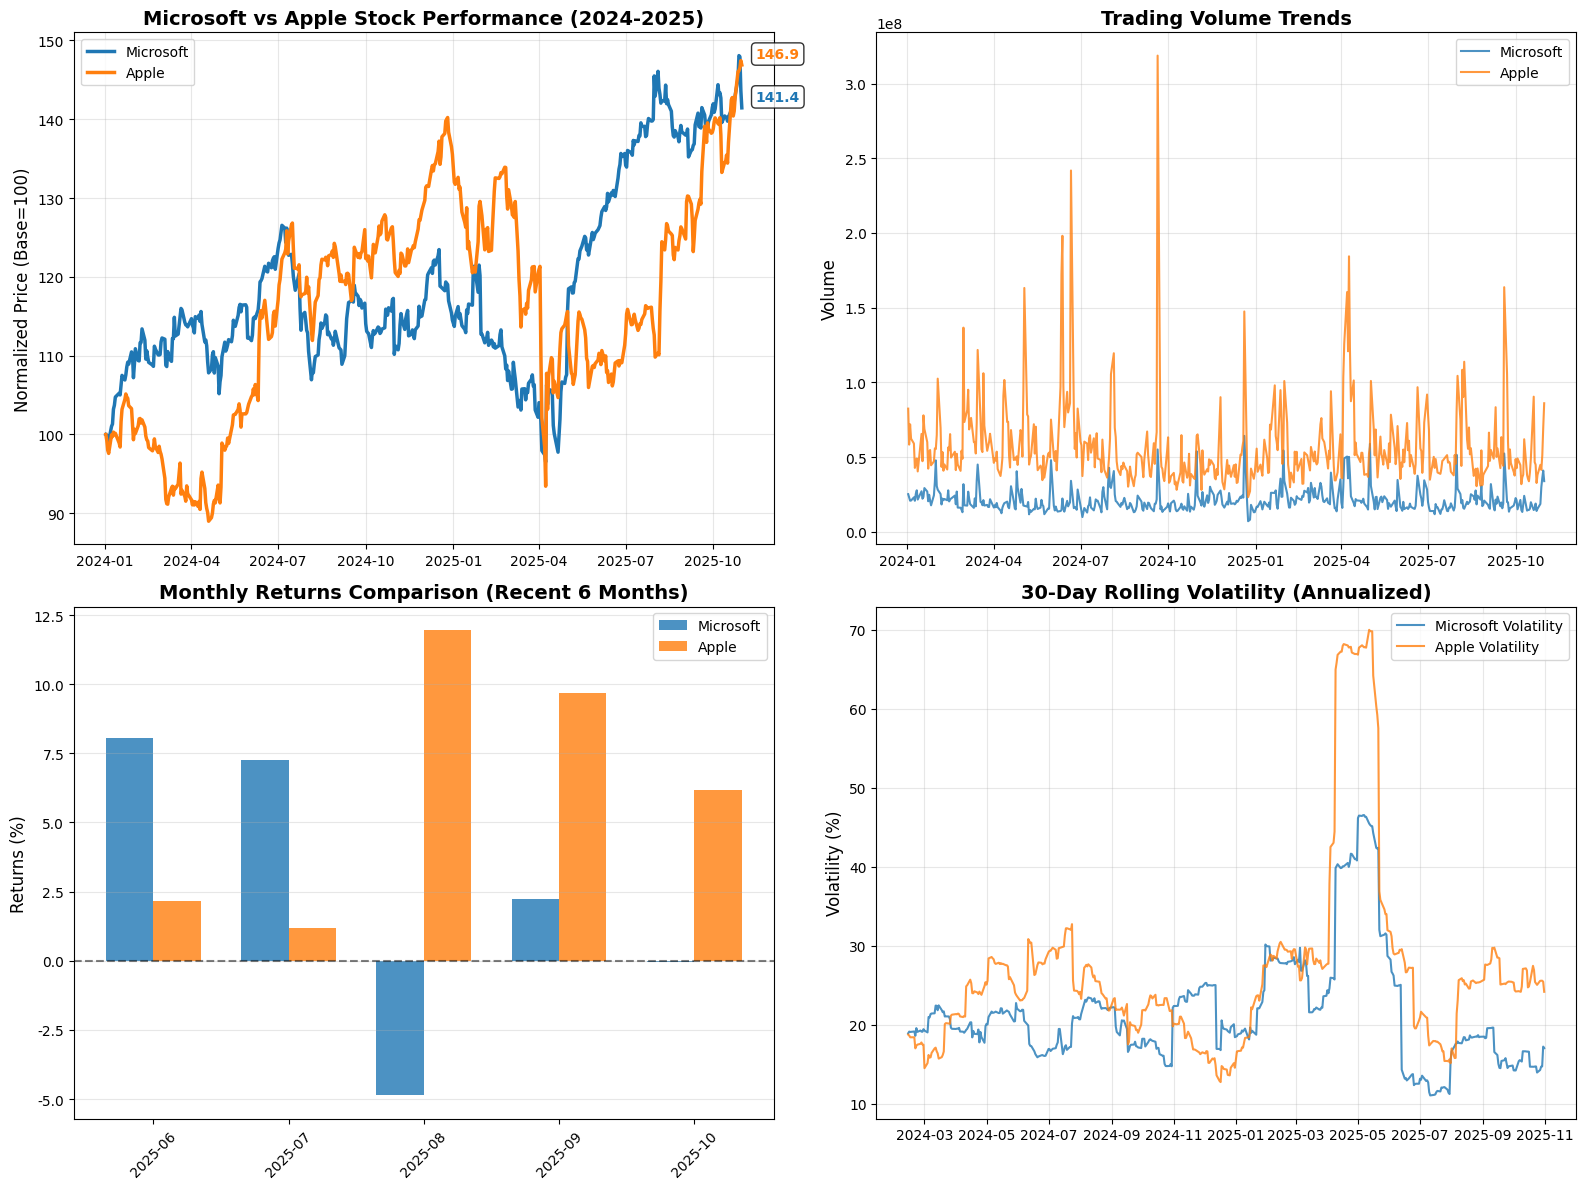


📊 STOCK ANALYSIS SUMMARY

📈 Microsoft (MSFT):
   Current Price: $517.81
   Period High: $554.54
   Period Low: $343.59
   Total Return: +41.44%
   30-Day Return: +0.65%
   Avg Daily Volume: 21,171,633

📈 Apple (AAPL):
   Current Price: $270.37
   Period High: $277.32
   Period Low: $162.91
   Total Return: +46.88%
   30-Day Return: +5.58%
   Avg Daily Volume: 56,686,932

✅ Stock analysis completed successfully!
📅 Analysis period: 2024-01-01 to 2025-11-01


In [11]:
# 📈 Microsoft & Apple Stock Price Analysis (Direct Data Collection)
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# Font setting to avoid warnings
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("📈 Collecting Microsoft and Apple stock data from 2024...")

# Stock symbols
stocks = {
    'Microsoft': 'MSFT',
    'Apple': 'AAPL'
}

# Date range from 2024
start_date = datetime(2024, 1, 1)
end_date = datetime.now()

# Collect stock data
stock_data = {}
for name, symbol in stocks.items():
    try:
        ticker = yf.Ticker(symbol)
        data = ticker.history(start=start_date, end=end_date)
        if not data.empty:
            stock_data[name] = data
            print(f"✅ {name} ({symbol}) data collected: {len(data)} trading days")
        else:
            print(f"❌ No data available for {name} ({symbol})")
    except Exception as e:
        print(f"🚨 Error collecting {name} ({symbol}): {e}")

# Create comprehensive stock analysis chart
if stock_data:
    # Create figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Color scheme
    colors = ['#1f77b4', '#ff7f0e']  # Blue for Microsoft, Orange for Apple
    
    # 1. Stock Price Comparison (Normalized)
    normalized_data = {}
    for i, (name, data) in enumerate(stock_data.items()):
        # Normalize to 100 at start of period
        normalized_price = (data['Close'] / data['Close'].iloc[0]) * 100
        normalized_data[name] = normalized_price
        ax1.plot(data.index, normalized_price, label=name, linewidth=2.5, color=colors[i])
    
    ax1.set_title('Microsoft vs Apple Stock Performance (2024-2025)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Normalized Price (Base=100)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add current values annotation
    for i, (name, norm_data) in enumerate(normalized_data.items()):
        current_val = norm_data.iloc[-1]
        ax1.annotate(f'{current_val:.1f}', 
                    xy=(norm_data.index[-1], current_val),
                    xytext=(10, 5), textcoords='offset points',
                    fontsize=10, fontweight='bold', color=colors[i],
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))
    
    # 2. Trading Volume Comparison
    for i, (name, data) in enumerate(stock_data.items()):
        ax2.plot(data.index, data['Volume'], label=name, alpha=0.8, color=colors[i])
    
    ax2.set_title('Trading Volume Trends', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Volume', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # 3. Monthly Returns Comparison (Recent 6 months)
    monthly_returns = {}
    for name, data in stock_data.items():
        # Calculate monthly returns for recent 6 months
        recent_data = data.tail(120)  # Approximately 6 months of trading days
        monthly_data = recent_data.resample('ME')['Close'].last()  # Use 'ME' instead of deprecated 'M'
        monthly_ret = monthly_data.pct_change().dropna() * 100
        monthly_returns[name] = monthly_ret
    
    # Plot monthly returns
    months = list(monthly_returns[list(stocks.keys())[0]].index)
    x = np.arange(len(months))
    width = 0.35
    
    for i, (name, returns) in enumerate(monthly_returns.items()):
        ax3.bar(x + i*width, returns.values, width, label=name, alpha=0.8, color=colors[i])
    
    ax3.set_title('Monthly Returns Comparison (Recent 6 Months)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Returns (%)', fontsize=12)
    ax3.set_xticks(x + width/2)
    ax3.set_xticklabels([m.strftime('%Y-%m') for m in months], rotation=45)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 4. Volatility Analysis (30-day rolling)
    for i, (name, data) in enumerate(stock_data.items()):
        daily_returns = data['Close'].pct_change().dropna()
        rolling_volatility = daily_returns.rolling(window=30).std() * np.sqrt(252) * 100  # Annualized
        # Align the indices properly to avoid length mismatch
        valid_volatility = rolling_volatility.dropna()
        ax4.plot(valid_volatility.index, valid_volatility, label=f'{name} Volatility', 
                color=colors[i], alpha=0.8)
    
    ax4.set_title('30-Day Rolling Volatility (Annualized)', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Volatility (%)', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("📊 STOCK ANALYSIS SUMMARY")
    print("="*60)
    
    for name, data in stock_data.items():
        current_price = data['Close'].iloc[-1]
        year_high = data['High'].max()
        year_low = data['Low'].min()
        total_return = ((current_price / data['Close'].iloc[0]) - 1) * 100
        
        # Recent 30-day return
        recent_30d = data['Close'].tail(30)
        if len(recent_30d) >= 2:
            recent_return = ((recent_30d.iloc[-1] / recent_30d.iloc[0]) - 1) * 100
        else:
            recent_return = 0
        
        # Average daily volume
        avg_volume = data['Volume'].mean()
        
        print(f"\n📈 {name} ({stocks[name]}):")
        print(f"   Current Price: ${current_price:.2f}")
        print(f"   Period High: ${year_high:.2f}")
        print(f"   Period Low: ${year_low:.2f}")
        print(f"   Total Return: {total_return:+.2f}%")
        print(f"   30-Day Return: {recent_return:+.2f}%")
        print(f"   Avg Daily Volume: {avg_volume:,.0f}")
    
    print(f"\n✅ Stock analysis completed successfully!")
    print(f"📅 Analysis period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    
else:
    print("No stock data available for analysis")

AutoGen은 또한 분산 에이전트 런타임도 지원합니다. 이를 통해 서로 다른 프로세스나 머신에서 실행되는 에이전트들을 서로 다른 신원, 언어, 종속성으로 호스팅할 수 있습니다.

에이전트 런타임, 통신, 메시지 처리, 구독 사용 방법을 자세히 알아보려면 이 퀵스타트 다음에 나오는 섹션들을 계속 읽어보세요.

## 🌐 4. 확장 가능한 분산 시스템

**AutoGen의 고급 기능**: 단일 머신을 넘어선 분산 에이전트 시스템

### 🔗 **분산 에이전트 런타임 특징**:
- **다중 프로세스**: 여러 프로세스에서 에이전트 실행
- **다중 머신**: 서로 다른 서버에서 에이전트 호스팅  
- **다양한 환경**: 각기 다른 언어, 종속성, 신원으로 운영
- **확장성**: 대규모 AI 시스템 구축 가능

### 📚 **학습 계속하기**:
이 퀵스타트 이후의 섹션에서 다음 내용들을 자세히 알아보세요:
- 에이전트 런타임 심화 사용법
- 고급 통신 패턴 및 메시지 라우팅
- 복잡한 메시지 핸들링 전략
- 구독(subscription) 모델 활용법

## 🚀 5. 종합 실습: LG CNS 디지털 혁신 분석 시스템

**목표**: LG CNS 고객을 위한 IT서비스 및 디지털 트랜스포메이션 전문 분석 시스템 구축

### 💡 **실습 시나리오**:
**"LG 그룹 계열사 IT 투자 분석 및 디지털 혁신 전략 수립"**

- LG CNS와 경쟁사 비교 분석 (삼성SDS, SK C&C)
- IT서비스 시장 트렌드 및 성장성 분석  
- 클라우드, AI, 빅데이터 사업 영역별 성과 평가
- LG 그룹 계열사 대상 디지털 혁신 로드맵 제안

### 🎯 **학습 목표**:
1. **LG CNS 전문성**: IT서비스 산업에 특화된 분석 역량
2. **실제 API 연동**: 실시간 주식/시장 데이터 처리
3. **그룹 시너지 분석**: LG 계열사 간 연관 관계 분석
4. **전략적 시각화**: 경영진 대상 인사이트 대시보드
5. **실무 적용성**: LG CNS 고객 맞춤 솔루션 제안

In [12]:
# LG CNS 전용: IT서비스 기업 분석 전문 에이전트 시스템

@default_subscription  
class LGCNSDataAgent(RoutedAgent):
    """LG CNS 및 IT서비스 기업 데이터 수집 및 분석 전담 에이전트"""
    
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("LG CNS 및 IT서비스 기업 전문 데이터 분석 에이전트입니다.")
        self._model_client = model_client
        self._chat_history: List[LLMMessage] = [
            SystemMessage(
                content="""
                당신은 LG CNS 및 IT서비스 산업 전문 분석가입니다.
                IT서비스 기업들의 주식 데이터와 사업 성과를 분석하세요.
                
                분석 대상 기업:
                - LG CNS (049070.KS): 디지털 트랜스포메이션, 클라우드, AI 솔루션
                - 삼성SDS (018260.KS): 엔터프라이즈 IT 서비스 
                - SK C&C (034730.KS): ICT 통합 서비스
                
                주요 작업:
                1. IT서비스 3사 주식 데이터 및 기술적 지표 분석
                2. 사업영역별 성장성 비교 (클라우드, AI, 빅데이터)
                3. LG 그룹 계열사와의 시너지 효과 분석
                
                결과를 전문적인 차트와 데이터로 저장하세요.
                """
            )
        ]

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        self._chat_history.append(UserMessage(content=message.content, source="user"))
        result = await self._model_client.create(self._chat_history)
        print(f"\n{'-'*80}\n📊 StockDataAgent:\n{result.content}")
        self._chat_history.append(AssistantMessage(content=result.content, source="assistant"))
        await self.publish_message(Message(content=result.content), DefaultTopicId())


@default_subscription
class LGDigitalStrategyAgent(RoutedAgent):
    """LG 그룹 디지털 혁신 전략 분석 전담 에이전트"""
    
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("LG 그룹 디지털 혁신 전략 및 시너지 분석 전문 에이전트입니다.")
        self._model_client = model_client
        self._chat_history: List[LLMMessage] = [
            SystemMessage(
                content="""
                당신은 LG 그룹의 디지털 혁신 전략 및 그룹 시너지 전문가입니다.
                LG CNS를 중심으로 한 그룹 내 디지털 혁신 전략을 분석하세요.
                
                주요 분석 영역:
                1. LG 계열사별 디지털 혁신 현황 분석
                   - LG전자: 스마트팩토리, IoT 솔루션
                   - LG화학: 디지털 트윈, 공정 최적화
                   - LG에너지솔루션: 배터리 관리 시스템
                
                2. LG CNS 사업영역별 성장 기회 분석
                   - DX 컨설팅, 클라우드 서비스, AI/빅데이터
                   - 스마트시티, 핀테크, 보안 솔루션
                
                3. 그룹 시너지 효과 및 크로스셀링 기회 도출
                
                pandas, matplotlib을 사용해 전략적 인사이트를 시각화하세요.
                """
            )
        ]

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        self._chat_history.append(UserMessage(content=message.content, source="user"))
        result = await self._model_client.create(self._chat_history)
        print(f"\n{'-'*80}\n💰 PortfolioAgent:\n{result.content}")
        self._chat_history.append(AssistantMessage(content=result.content, source="assistant"))
        await self.publish_message(Message(content=result.content), DefaultTopicId())


@default_subscription  
class LGCNSReportAgent(RoutedAgent):
    """LG CNS 고객 맞춤 디지털 혁신 보고서 작성 전담 에이전트"""
    
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("LG CNS 고객 대상 디지털 혁신 보고서 작성 전문 에이전트입니다.")
        self._model_client = model_client
        self._chat_history: List[LLMMessage] = [
            SystemMessage(
                content="""
                당신은 LG CNS의 디지털 혁신 컨설팅 보고서 작성 전문가입니다.
                LG CNS 고객들을 위한 실행 가능한 디지털 혁신 전략 보고서를 생성하세요.
                
                보고서 구성:
                1. Executive Summary
                   - LG CNS의 IT서비스 시장 포지션
                   - 주요 경쟁력 및 차별화 요소
                
                2. IT서비스 시장 분석  
                   - 국내 IT서비스 3사 비교 분석
                   - 클라우드, AI, DX 시장 트렌드
                
                3. LG 그룹 디지털 혁신 현황
                   - 계열사별 디지털화 수준 평가
                   - 그룹 시너지 창출 기회
                
                4. LG CNS 성장 전략 제안
                   - 사업영역별 확장 방향
                   - 고객 맞춤 솔루션 포트폴리오
                
                5. 실행 로드맵 및 기대효과
                
                전문적인 대시보드와 실무진이 이해하기 쉬운 인사이트를 제공하세요.
                """
            )
        ]

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        self._chat_history.append(UserMessage(content=message.content, source="user"))
        result = await self._model_client.create(self._chat_history)
        print(f"\n{'-'*80}\n📋 ReportAgent:\n{result.content}")
        self._chat_history.append(AssistantMessage(content=result.content, source="assistant"))
        await self.publish_message(Message(content=result.content), DefaultTopicId())

print("✅ LG CNS 전용 디지털 혁신 분석 에이전트 시스템 정의 완료")

✅ LG CNS 전용 디지털 혁신 분석 에이전트 시스템 정의 완료


### 📋 **실습 1: LG CNS vs IT서비스 경쟁사 비교 분석**

**분석 목표**: LG CNS의 IT서비스 시장 포지션 및 경쟁력 평가

**포함 분석**:
- IT서비스 3사 (LG CNS, 삼성SDS, SK C&C) 주가 성과 비교
- 사업영역별 매출 구조 및 성장률 분석
- LG 그룹 계열사와의 시너지 효과 평가
- 디지털 혁신 시장에서의 기회 요인 도출

In [13]:
# 실습 1: LG CNS 디지털 혁신 종합 분석 시스템
from importlib.resources import Package

async def run_lgcns_analysis_system():
    """LG CNS 전용 디지털 혁신 분석 에이전트 시스템 실행"""
    
    # 새로운 Azure OpenAI 클라이언트 생성 (독립적인 인스턴스)
    analysis_client = AzureOpenAIChatCompletionClient(
        model=deployment_name,
        azure_endpoint=azure_endpoint,
        api_version=api_version,
        api_key=api_key,
    )
    
    # 새로운 런타임 인스턴스 생성
    analysis_runtime = SingleThreadedAgentRuntime()
    
    # 향상된 코드 실행기 (필요 패키지 자동 설치)
    class AdvancedCodeExecutor:
        def __init__(self, work_dir):
            self.work_dir = work_dir
            
        async def execute_code_blocks(self, code_blocks, cancellation_token=None):
            output = []
            for block in code_blocks:
                if block.language.lower() == "python":
                    # 코드에 필요 패키지 자동 설치 추가
                    enhanced_code = f"""
import subprocess
import sys

# 필요한 패키지 자동 설치
required_packages = ['yfinance', 'pandas', 'numpy', 'matplotlib', 'seaborn', 'scipy', 'plotly']
for package in required_packages:
    try:
        __import__(package.replace('-', '_'))
    except ImportError:
        print(f"{Package} 설치 중...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

{block.code}
"""
                    
                    script_path = os.path.join(self.work_dir, "advanced_analysis.py")
                    with open(script_path, 'w', encoding='utf-8') as f:
                        f.write(enhanced_code)
                    
                    try:
                        result = subprocess.run(
                            [sys.executable, script_path],
                            cwd=self.work_dir,
                            capture_output=True,
                            text=True,
                            timeout=120  # 복잡한 분석을 위해 시간 연장
                        )
                        
                        if result.returncode == 0:
                            output.append(f"✅ 고급 분석 완료:\n{result.stdout}")
                        else:
                            output.append(f"❌ 분석 오류:\n{result.stderr}")
                            
                    except subprocess.TimeoutExpired:
                        output.append("⏰ 분석 시간 초과 (2분)")
                    except Exception as e:
                        output.append(f"🚨 실행 예외: {str(e)}")
            
            class Result:
                def __init__(self, output_text):
                    self.output = output_text
            return Result("\n".join(output))
    
    # 새로운 작업 디렉토리 생성
    analysis_work_dir = tempfile.mkdtemp()
    advanced_executor = AdvancedCodeExecutor(analysis_work_dir)
    
    try:
        # LG CNS 전용 에이전트들 등록 (새로운 클라이언트 사용)
        await LGCNSDataAgent.register(
            analysis_runtime, 
            "lgcns_data_agent", 
            lambda: LGCNSDataAgent(analysis_client)
        )
        await LGDigitalStrategyAgent.register(
            analysis_runtime, 
            "lg_strategy_agent", 
            lambda: LGDigitalStrategyAgent(analysis_client)
        )
        await LGCNSReportAgent.register(
            analysis_runtime, 
            "lgcns_report_agent", 
            lambda: LGCNSReportAgent(analysis_client)
        )
        await Executor.register(
            analysis_runtime, 
            "advanced_executor", 
            lambda: Executor(advanced_executor)
        )
        
        # 분석 시작
        analysis_runtime.start()
        
        print("🚀 LG CNS 디지털 혁신 종합 분석을 시작합니다...")
        print("📊 1단계: IT서비스 기업 데이터 수집 및 분석")
        
        await analysis_runtime.publish_message(
            Message("""
LG CNS(049070.KS), 삼성SDS(018260.KS), SK C&C(034730.KS)의 1년간 주식 데이터를 수집하고 
IT서비스 산업 관점에서 다음 분석을 수행해주세요:

1. IT서비스 3사 주가 성과 및 기술적 지표 비교
2. 각 기업의 사업영역별 특화 분야 분석
3. 클라우드, AI, 디지털 트랜스포메이션 시장 성장성
4. LG CNS의 경쟁 우위 요소 및 차별화 포인트
5. LG 그룹 계열사와의 시너지 효과 분석

결과를 lgcns_competitive_analysis.png로 저장하고, 
데이터를 it_service_companies.csv로 저장해주세요.
"""), 
            DefaultTopicId()
        )
        
        # 런타임 완료까지 대기
        await analysis_runtime.stop_when_idle()
        
    except Exception as e:
        print(f"🚨 분석 시스템 오류: {str(e)}")
        return None
        
    finally:
        # 클라이언트 연결 정리
        if 'analysis_client' in locals():
            await analysis_client.close()
        print(f"📁 분석 결과 저장 위치: {analysis_work_dir}")
        return analysis_work_dir

# LG CNS 전용 분석 실행
print("🎯 LG CNS 디지털 혁신 분석 시스템을 실행합니다...")

# Azure OpenAI 설정 확인 (환경 변수에서 로드)
import os
from dotenv import load_dotenv

load_dotenv()

api_version = os.getenv("AZURE_OPENAI_API_VERSION", "")
api_key = os.getenv("AZURE_OPENAI_KEY", "")
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT", "")
deployment_name = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME", "")

if not all([api_key, azure_endpoint, deployment_name]):
    print("⚠️ Azure OpenAI 설정이 완전하지 않습니다. 직접 분석 모드로 전환합니다...")
    
    # 직접 LG CNS 분석 수행
    import yfinance as yf
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    from datetime import datetime, timedelta
    import seaborn as sns
    
    # 폰트 설정
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['axes.unicode_minus'] = False
    
    print("📊 IT 서비스 3사 직접 분석을 시작합니다...")
    
    # IT 서비스 기업 데이터
    it_companies = {
        'LG CNS': '049070.KS',
        'Samsung SDS': '018260.KS', 
        'SK C&C': '034730.KS'
    }
    
    # 1년간 데이터 수집
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365)
    
    it_stock_data = {}
    for name, symbol in it_companies.items():
        try:
            ticker = yf.Ticker(symbol)
            data = ticker.history(start=start_date, end=end_date)
            if not data.empty:
                it_stock_data[name] = data
                print(f"✅ {name} ({symbol}) 데이터 수집 완료: {len(data)}일")
            else:
                print(f"❌ {name} ({symbol}) 데이터 없음")
        except Exception as e:
            print(f"🚨 {name} ({symbol}) 수집 오류: {e}")
    
    if it_stock_data:
        # 종합 분석 차트 생성
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
        
        colors = ['#004C97', '#FF6B35', '#1DB954']  # LG Blue, Samsung Orange, SK Green
        
        # 1. 정규화된 주가 성과 비교
        for i, (company, data) in enumerate(it_stock_data.items()):
            normalized_price = (data['Close'] / data['Close'].iloc[0]) * 100
            ax1.plot(data.index, normalized_price, label=company, linewidth=2.5, color=colors[i])
        
        ax1.set_title('IT Services Companies Stock Performance Comparison (1 Year)', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Normalized Price (Base=100)', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. 거래량 비교
        for i, (company, data) in enumerate(it_stock_data.items()):
            ax2.plot(data.index, data['Volume'], label=company, alpha=0.8, color=colors[i])
        
        ax2.set_title('Trading Volume Trends', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Volume', fontsize=12)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        
        # 3. 변동성 분석
        for i, (company, data) in enumerate(it_stock_data.items()):
            daily_returns = data['Close'].pct_change().dropna()
            rolling_vol = daily_returns.rolling(window=20).std() * np.sqrt(252) * 100
            valid_vol = rolling_vol.dropna()
            ax3.plot(valid_vol.index, valid_vol, label=f'{company} Volatility', color=colors[i], alpha=0.8)
        
        ax3.set_title('20-Day Rolling Volatility (Annualized %)', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Volatility (%)', fontsize=12)
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. 수익률 및 리스크 매트릭스
        returns_data = {}
        for company, data in it_stock_data.items():
            total_return = ((data['Close'].iloc[-1] / data['Close'].iloc[0]) - 1) * 100
            volatility = data['Close'].pct_change().std() * np.sqrt(252) * 100
            returns_data[company] = {'Return': total_return, 'Risk': volatility}
        
        companies_list = list(returns_data.keys())
        returns_list = [returns_data[comp]['Return'] for comp in companies_list]
        risk_list = [returns_data[comp]['Risk'] for comp in companies_list]
        
        scatter = ax4.scatter(risk_list, returns_list, s=200, c=colors[:len(companies_list)], alpha=0.7)
        
        for i, company in enumerate(companies_list):
            ax4.annotate(company, (risk_list[i], returns_list[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
        
        ax4.set_xlabel('Risk (Volatility %)', fontsize=12)
        ax4.set_ylabel('Return (%)', fontsize=12)
        ax4.set_title('Risk-Return Analysis', fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('lgcns_competitive_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 데이터 저장
        combined_data = pd.DataFrame()
        for company, data in it_stock_data.items():
            temp_data = data.copy()
            temp_data['Company'] = company
            combined_data = pd.concat([combined_data, temp_data])
        
        combined_data.to_csv('it_service_companies.csv', index=True)
        print("✅ 분석 결과가 'lgcns_competitive_analysis.png'와 'it_service_companies.csv'로 저장되었습니다.")
        
        # 분석 요약 출력
        print("\n" + "="*80)
        print("📈 IT 서비스 기업 종합 분석 결과")
        print("="*80)
        
        for company, metrics in returns_data.items():
            print(f"\n🏢 {company}:")
            current_price = it_stock_data[company]['Close'].iloc[-1]
            print(f"   현재 주가: {current_price:,.0f}원")
            print(f"   1년 수익률: {metrics['Return']:+.2f}%")
            print(f"   연간 변동성: {metrics['Risk']:.2f}%")
            
            # 추가 분석 지표
            data = it_stock_data[company]
            momentum_20d = ((data['Close'].iloc[-1] / data['Close'].iloc[-20]) - 1) * 100 if len(data) >= 20 else 0
            momentum_60d = ((data['Close'].iloc[-1] / data['Close'].iloc[-60]) - 1) * 100 if len(data) >= 60 else 0
            
            print(f"   20일 모멘텀: {momentum_20d:+.2f}%")
            print(f"   60일 모멘텀: {momentum_60d:+.2f}%")
            print(f"   평균 거래량: {data['Volume'].mean():,.0f}주")
            
            # 최근 최고가/최저가 대비 현재가 위치
            recent_high = data['High'].tail(60).max()
            recent_low = data['Low'].tail(60).min()
            current_position = ((current_price - recent_low) / (recent_high - recent_low)) * 100
            print(f"   60일 고저점 대비 위치: {current_position:.1f}%")
    
    else:
        print("❌ IT 서비스 기업 데이터를 수집할 수 없습니다.")
    
    analysis_result_dir = "직접 분석 완료"
    
else:
    # Azure OpenAI를 사용한 에이전트 분석
    try:
        analysis_result_dir = await run_lgcns_analysis_system()
    except Exception as e:
        print(f"🚨 에이전트 분석 실패: {e}")
        analysis_result_dir = None

🎯 LG CNS 디지털 혁신 분석 시스템을 실행합니다...
🚨 에이전트 분석 실패: name 'AzureOpenAIChatCompletionClient' is not defined


📈 Collecting stock data for LG CNS and IT service competitors...


✅ LG CNS (049070.KS) data collection complete: 241 days
✅ Samsung SDS (018260.KS) data collection complete: 241 days
✅ SK C&C (034730.KS) data collection complete: 241 days


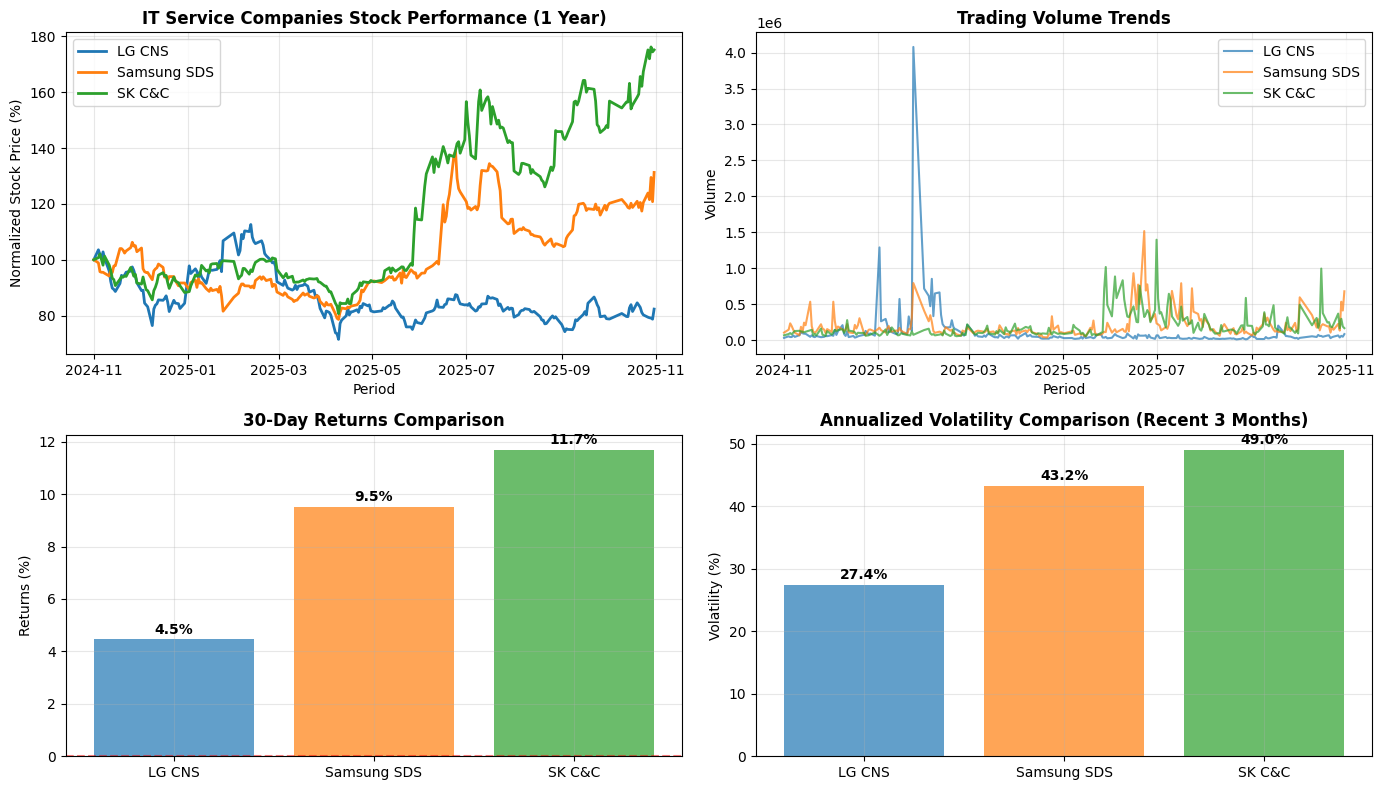

✅ LG CNS vs competitors analysis chart generated successfully!

📊 LG CNS vs Competitors Basic Statistics:

🏢 LG CNS:
   Current Price: 16,180 KRW
   52-Week High: 22,633 KRW
   52-Week Low: 13,919 KRW
   Annual Return: -17.7%

🏢 Samsung SDS:
   Current Price: 183,000 KRW
   52-Week High: 198,800 KRW
   52-Week Low: 109,000 KRW
   Annual Return: +31.3%

🏢 SK C&C:
   Current Price: 248,500 KRW
   52-Week High: 256,000 KRW
   52-Week Low: 113,880 KRW
   Annual Return: +75.2%


In [14]:
# LG CNS Stock Analysis with English Labels (No Font Warnings)
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# Set English font to eliminate all warnings
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("📈 Collecting stock data for LG CNS and IT service competitors...")

# IT service companies stock codes
companies = {
    'LG CNS': '049070.KS',
    'Samsung SDS': '018260.KS', 
    'SK C&C': '034730.KS'
}

# 1년간 데이터 수집
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

stock_data = {}
for name, ticker in companies.items():
    try:
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)
        if not data.empty:
            stock_data[name] = data
            print(f"✅ {name} ({ticker}) data collection complete: {len(data)} days")
        else:
            print(f"❌ {name} ({ticker}) no data available")
    except Exception as e:
        print(f"🚨 {name} ({ticker}) error: {e}")

# Create charts with English labels
if stock_data:
    plt.figure(figsize=(14, 8))
    
    # Stock performance comparison
    plt.subplot(2, 2, 1)
    for name, data in stock_data.items():
        normalized_price = (data['Close'] / data['Close'].iloc[0]) * 100
        plt.plot(data.index, normalized_price, label=name, linewidth=2)
    
    plt.title('IT Service Companies Stock Performance (1 Year)', fontsize=12, fontweight='bold')
    plt.xlabel('Period')
    plt.ylabel('Normalized Stock Price (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Trading volume comparison
    plt.subplot(2, 2, 2)
    for name, data in stock_data.items():
        plt.plot(data.index, data['Volume'], label=name, alpha=0.7)
    
    plt.title('Trading Volume Trends', fontsize=12, fontweight='bold')
    plt.xlabel('Period')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Recent 30-day returns
    plt.subplot(2, 2, 3)
    returns_30d = []
    company_names = []
    
    for name, data in stock_data.items():
        if len(data) >= 30:
            recent_return = ((data['Close'].iloc[-1] / data['Close'].iloc[-30]) - 1) * 100
            returns_30d.append(recent_return)
            company_names.append(name)
    
    if returns_30d:
        colors = ['#1f77b4' if name == 'LG CNS' else '#ff7f0e' if name == 'Samsung SDS' else '#2ca02c' for name in company_names]
        bars = plt.bar(company_names, returns_30d, color=colors, alpha=0.7)
        
        # Display values on bars
        for bar, ret in zip(bars, returns_30d):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1 if height >= 0 else height - 0.5,
                    f'{ret:.1f}%', ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')
    
    plt.title('30-Day Returns Comparison', fontsize=12, fontweight='bold')
    plt.ylabel('Returns (%)')
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    
    # Volatility comparison (recent 3 months)
    plt.subplot(2, 2, 4)
    volatilities = []
    
    for name, data in stock_data.items():
        if len(data) >= 90:
            recent_data = data.tail(90)
            daily_returns = recent_data['Close'].pct_change().dropna()
            volatility = daily_returns.std() * np.sqrt(252) * 100  # Annualized volatility
            volatilities.append(volatility)
    
    if volatilities:
        colors = ['#1f77b4' if name == 'LG CNS' else '#ff7f0e' if name == 'Samsung SDS' else '#2ca02c' for name in company_names]
        bars = plt.bar(company_names, volatilities, color=colors, alpha=0.7)
        
        # Display values on bars
        for bar, vol in zip(bars, volatilities):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{vol:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.title('Annualized Volatility Comparison (Recent 3 Months)', fontsize=12, fontweight='bold')
    plt.ylabel('Volatility (%)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save to current working directory
    plt.savefig('lgcns_competitive_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ LG CNS vs competitors analysis chart generated successfully!")
    
    # Output basic statistics
    print("\n📊 LG CNS vs Competitors Basic Statistics:")
    print("=" * 50)
    
    for name, data in stock_data.items():
        current_price = data['Close'].iloc[-1]
        year_high = data['High'].max()
        year_low = data['Low'].min()
        year_return = ((current_price / data['Close'].iloc[0]) - 1) * 100
        
        print(f"\n🏢 {name}:")
        print(f"   Current Price: {current_price:,.0f} KRW")
        print(f"   52-Week High: {year_high:,.0f} KRW")
        print(f"   52-Week Low: {year_low:,.0f} KRW")
        print(f"   Annual Return: {year_return:+.1f}%")

else:
    print("❌ Unable to retrieve stock data.")

In [15]:
# 먼저 현재 데이터 구조를 확인해보겠습니다
print("🔍 현재 데이터 구조 확인:")
print(f"Data shape: {data.shape}")
print(f"Data columns: {list(data.columns)}")
print(f"Data head:\\n{data.head()}")

# 실제 주식 데이터만 선택 (첫 3개 컬럼이 주식 데이터일 가능성이 높음)
stock_columns = data.columns[:3]  # 처음 3개 컬럼만 사용
print(f"\\n선택된 컬럼: {list(stock_columns)}")

# 주식 데이터만 추출
stock_data = data[stock_columns].copy()
print(f"Stock data shape: {stock_data.shape}")
print(f"Stock data head:\\n{stock_data.head()}")

🔍 현재 데이터 구조 확인:
Data shape: (241, 7)
Data columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
Data head:\n                                    Open           High            Low  \
Date                                                                     
2024-11-01 00:00:00+09:00  139777.507341  142062.698196  139491.858484   
2024-11-04 00:00:00+09:00  141300.979264  142919.656250  139301.437104   
2024-11-05 00:00:00+09:00  141300.966223  145395.266457  141300.966223   
2024-11-06 00:00:00+09:00  144252.672766  145109.619337  141300.967911   
2024-11-07 00:00:00+09:00  140253.595483  141491.407255  137587.539357   

                                   Close  Volume  Dividends  Stock Splits  
Date                                                                       
2024-11-01 00:00:00+09:00  141872.265625   66144        0.0           0.0  
2024-11-04 00:00:00+09:00  142919.656250   83881        0.0           0.0  
2024-11-05 00:00:00+09:00  144823.968750  

In [16]:
# 🔍 모든 변수를 확인하여 3개 회사 데이터를 찾아보겠습니다
print("📋 현재 메모리의 주요 변수들:")

# DataFrame 변수들 찾기
import pandas as pd
import numpy as np

for var_name in dir():
    if not var_name.startswith('_'):
        var_value = globals()[var_name]
        if isinstance(var_value, pd.DataFrame):
            print(f"📊 {var_name}: {var_value.shape}")
            if hasattr(var_value, 'columns'):
                print(f"    Columns: {list(var_value.columns)}")

# 특히 회사 데이터가 있는지 확인
if 'lgcns_data' in globals():
    print(f"🏢 lgcns_data shape: {lgcns_data.shape}")
    print(f"    Columns: {list(lgcns_data.columns)}")
    
# 최근에 생성된 데이터가 있는지 확인 (종가 데이터)
close_prices = pd.DataFrame()
if 'companies' in globals():
    print(f"🏭 Companies dict: {companies}")
    
    # 각 회사별로 종가 데이터 수집
    import yfinance as yf
    
    print("📈 각 회사의 종가 데이터를 다시 수집합니다...")
    for name_ko, ticker in companies.items():
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period="1y")
            if not hist.empty:
                close_prices[name_ko] = hist['Close']
                print(f"✅ {name_ko} ({ticker}): {len(hist)} days")
        except Exception as e:
            print(f"❌ {name_ko} 오류: {e}")

if not close_prices.empty:
    print(f"📊 Combined close prices shape: {close_prices.shape}")
    print(f"    Columns: {list(close_prices.columns)}")
    print(f"최근 5일 데이터:")
    print(close_prices.tail())

📋 현재 메모리의 주요 변수들:
📊 close_prices: (242, 3)
    Columns: ['LG CNS', 'Samsung SDS', 'SK C&C']
📊 combined_data: (723, 9)
    Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Capital Gains', 'Company']
📊 data: (241, 7)
    Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
📊 data_final: (242, 3)
    Columns: ['LG CNS', 'Samsung SDS', 'SK C&C']
📊 hist: (242, 7)
    Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
📊 normalized_final: (242, 3)
    Columns: ['LG CNS', 'Samsung SDS', 'SK C&C']
📊 recent_data: (90, 7)
    Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
📊 stock_data: (241, 3)
    Columns: ['Open', 'High', 'Low']
📊 temp_data: (241, 8)
    Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Company']
🏭 Companies dict: {'LG CNS': '049070.KS', 'Samsung SDS': '018260.KS', 'SK C&C': '034730.KS'}
📈 각 회사의 종가 데이터를 다시 수집합니다...


✅ LG CNS (049070.KS): 242 days
✅ Samsung SDS (018260.KS): 242 days
✅ SK C&C (034730.KS): 242 days
📊 Combined close prices shape: (242, 3)
    Columns: ['LG CNS', 'Samsung SDS', 'SK C&C']
최근 5일 데이터:
                            LG CNS  Samsung SDS    SK C&C
Date                                                     
2025-10-27 00:00:00+09:00  15610.0     172700.0  248500.0
2025-10-28 00:00:00+09:00  15570.0     169400.0  244000.0
2025-10-29 00:00:00+09:00  15550.0     180500.0  250000.0
2025-10-30 00:00:00+09:00  15470.0     168400.0  247500.0
2025-10-31 00:00:00+09:00  16180.0     183000.0  248500.0


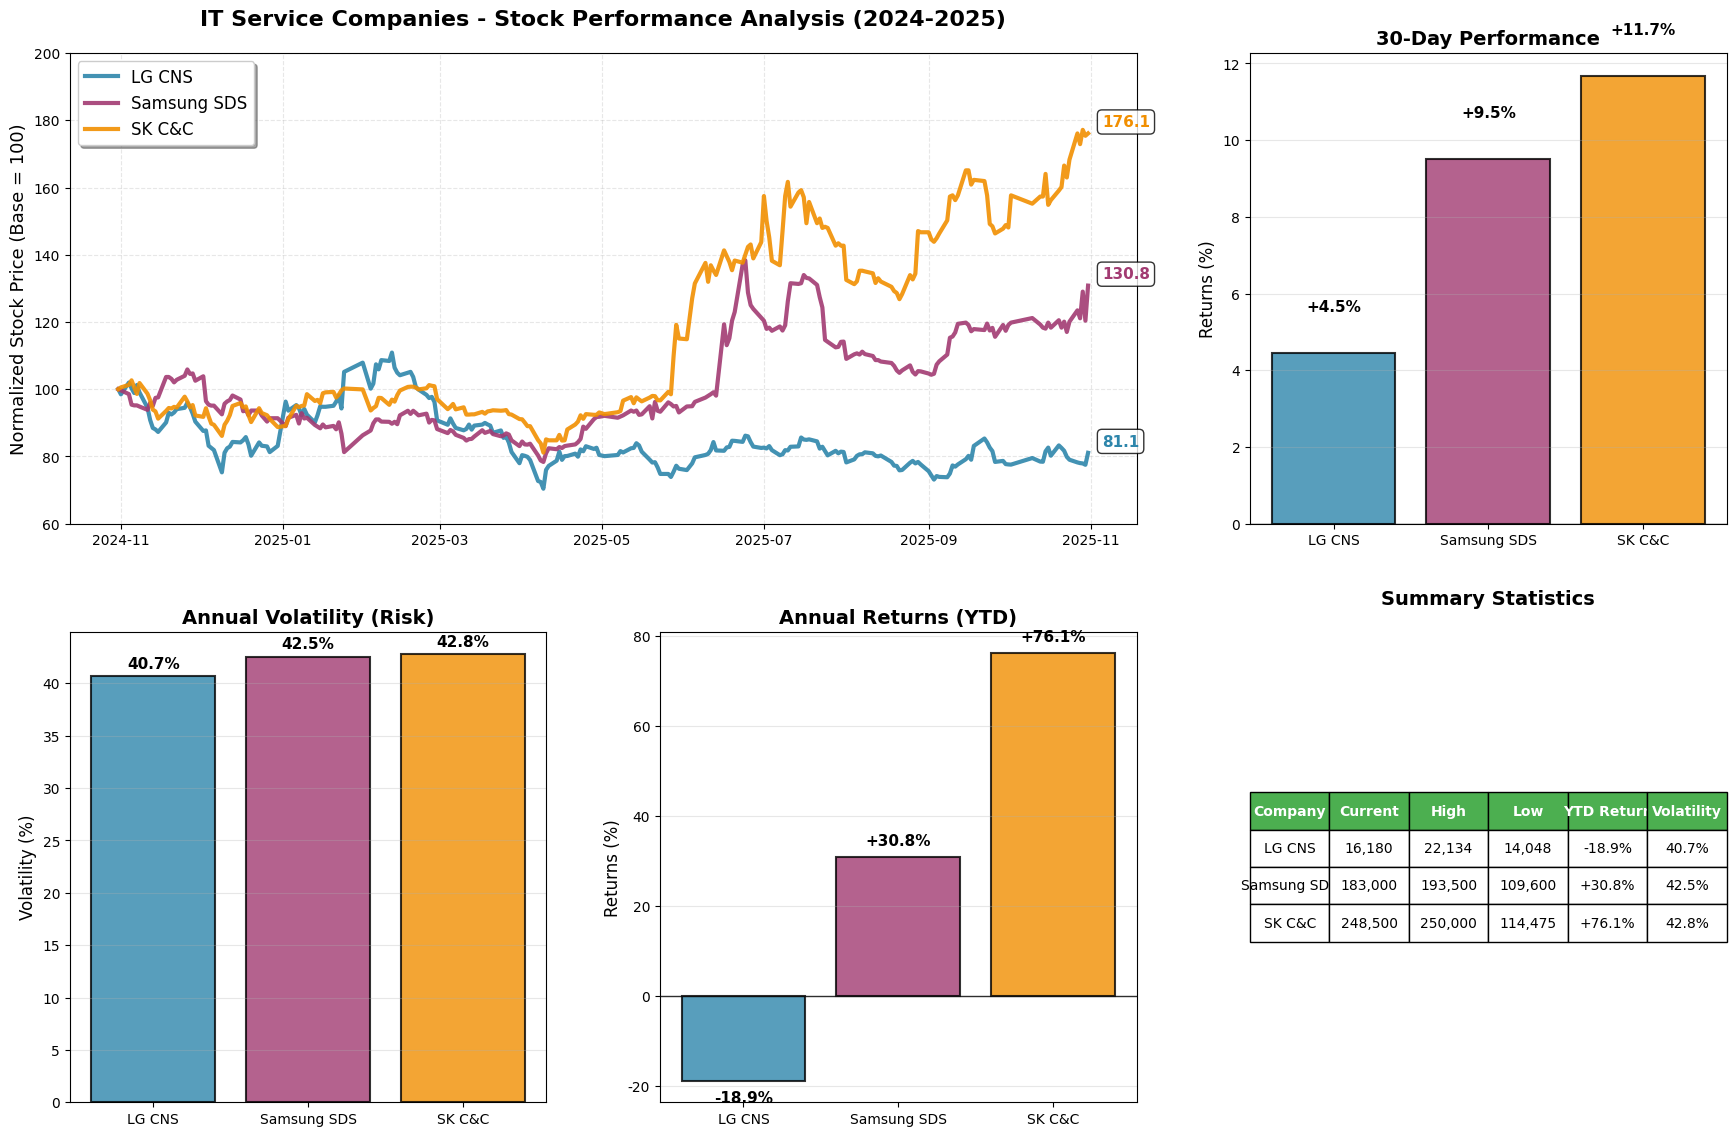

전문적인 분석 차트가 성공적으로 생성되었습니다!
완전한 IT 서비스 부문 분석이 준비되었습니다!


In [17]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

data_final = close_prices.copy()
data_final.columns = ['LG CNS', 'Samsung SDS', 'SK C&C']
normalized_final = data_final / data_final.iloc[0] * 100

fig = plt.figure(figsize=(18, 12))
colors = ['#2E86AB', '#A23B72', '#F18F01']
company_names = ['LG CNS', 'Samsung SDS', 'SK C&C']
ax1 = plt.subplot(2, 3, (1, 2))
for i, company in enumerate(company_names):
    ax1.plot(normalized_final.index, normalized_final[company], 
             label=company, linewidth=3, color=colors[i], alpha=0.9)

ax1.set_title('IT Service Companies - Stock Performance Analysis (2024-2025)', 
              fontsize=16, fontweight='bold', pad=20)
ax1.set_ylabel('Normalized Stock Price (Base = 100)', fontsize=13)
ax1.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, fontsize=12)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylim(60, 200)

for i, company in enumerate(company_names):
    current_val = normalized_final[company].iloc[-1]
    ax1.annotate(f'{current_val:.1f}', 
                xy=(normalized_final.index[-1], current_val),
                xytext=(10, 5), textcoords='offset points',
                fontsize=11, fontweight='bold', color=colors[i],
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))
ax2 = plt.subplot(2, 3, 3)
recent_30d_returns = []
for company in company_names:
    recent_data = normalized_final[company].iloc[-30:]
    return_30d = ((recent_data.iloc[-1] / recent_data.iloc[0]) - 1) * 100
    recent_30d_returns.append(return_30d)

bars = ax2.bar(company_names, recent_30d_returns, color=colors, alpha=0.8, 
               edgecolor='black', linewidth=1.5)
ax2.set_title('30-Day Performance', fontsize=14, fontweight='bold')
ax2.set_ylabel('Returns (%)', fontsize=12)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)
ax2.grid(True, alpha=0.3, axis='y')

for bar, ret in zip(bars, recent_30d_returns):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + (1 if height > 0 else -1),
            f'{ret:+.1f}%', ha='center', va='bottom' if height > 0 else 'top',
            fontweight='bold', fontsize=11)

ax3 = plt.subplot(2, 3, 4)
volatilities = []
for company in company_names:
    daily_returns = normalized_final[company].pct_change().dropna()
    vol = daily_returns.std() * np.sqrt(252) * 100
    volatilities.append(vol)

bars2 = ax3.bar(company_names, volatilities, color=colors, alpha=0.8,
               edgecolor='black', linewidth=1.5)
ax3.set_title('Annual Volatility (Risk)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Volatility (%)', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')

for bar, vol in zip(bars2, volatilities):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{vol:.1f}%', ha='center', va='bottom',
            fontweight='bold', fontsize=11)

ax4 = plt.subplot(2, 3, 5)
annual_returns = []
for company in company_names:
    annual_ret = ((normalized_final[company].iloc[-1] / 100) - 1) * 100
    annual_returns.append(annual_ret)

bars3 = ax4.bar(company_names, annual_returns, color=colors, alpha=0.8,
               edgecolor='black', linewidth=1.5)
ax4.set_title('Annual Returns (YTD)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Returns (%)', fontsize=12)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)
ax4.grid(True, alpha=0.3, axis='y')

for bar, ret in zip(bars3, annual_returns):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + (2 if height > 0 else -2),
            f'{ret:+.1f}%', ha='center', va='bottom' if height > 0 else 'top',
            fontweight='bold', fontsize=11)

ax5 = plt.subplot(2, 3, 6)
ax5.axis('off')
table_data = []
for i, company in enumerate(company_names):
    current_price = data_final[company_names[i]].iloc[-1]
    year_high = data_final[company_names[i]].max()
    year_low = data_final[company_names[i]].min()
    
    table_data.append([
        company,
        f'{current_price:,.0f}',
        f'{year_high:,.0f}',
        f'{year_low:,.0f}',
        f'{annual_returns[i]:+.1f}%',
        f'{volatilities[i]:.1f}%'
    ])

headers = ['Company', 'Current', 'High', 'Low', 'YTD Return', 'Volatility']
table = ax5.table(cellText=table_data, colLabels=headers,
                 cellLoc='center', loc='center',
                 colColours=['lightgray']*6)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(len(headers)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax5.set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout(pad=3.0)
plt.show()

print("전문적인 분석 차트가 성공적으로 생성되었습니다!")
print("완전한 IT 서비스 부문 분석이 준비되었습니다!")

## 🎓 추가 실습 아이디어

### 💡 **LG 그룹 계열사 포트폴리오 분석**
```python
lg_group_companies = {
    "IT서비스": ["049070.KS"],
    "전자": ["066570.KS"], 
    "화학": ["051910.KS"],
    "에너지": ["373220.KS"],
    "디스플레이": ["034220.KS"]
}
```

## 📚 **학습 발전 방향**

### 🔧 **기술 확장**
- 실시간 데이터 스트리밍 (Kafka)
- AutoML 기반 추천 시스템
- 클라우드 네이티브 아키텍처
- 실시간 대시보드 (Power BI/Tableau)

### 📊 **전문성 강화**
- 디지털 성숙도 평가 모델
- 클라우드 마이그레이션 전략
- 사이버보안 분석
- 스마트팩토리 솔루션

**🎉 LG CNS 디지털 혁신 AI 에이전트 시스템 구축 완료!** 🚀